<a href="https://colab.research.google.com/github/sharman-404/Stock-price-prediction/blob/main/stokx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

INSTALLING NECESSARY LIBRARIES

In [ ]:
#code cell 1
!pip install ta


IMPORT LIBRARIES

In [ ]:
#Code cell 2
# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# XGBoost model
import xgboost as xgb

# Deep learning (LSTM)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Technical indicators
import ta



IMPORT DATASET

In [ ]:
#Code cell 3
# Load the dataset
df = pd.read_csv("TataMotorsData.csv")
# Preview the first few rows
print("First 5 rows:")
print(df.head())
print(df.columns.tolist())
df.columns = df.columns.str.strip()  # removes any leading/trailing spaces
# Convert 'DATE' column to datetime format (your file uses uppercase 'DATE')
df['Date'] = pd.to_datetime(df['Date'])
# Sort the data by date in ascending order
df = df.sort_values('Date').reset_index(drop=True)
# Confirm the changes
print("\nDataset info:")
print(df.info())



First 5 rows:
         Date  series    OPEN    HIGH     LOW  PREV. CLOSE     ltp   close   \
0  04-Jul-2025      EQ  691.00  692.85  686.35       690.40  688.00  689.05   
1  03-Jul-2025      EQ  693.85  696.95  688.50       688.55  690.30  690.40   
2  02-Jul-2025      EQ  683.80  692.45  680.65       683.80  687.80  688.55   
3  01-Jul-2025      EQ  691.10  693.85  680.40       688.00  683.80  683.80   
4  30-Jun-2025      EQ  688.90  691.90  685.00       686.90  688.30  688.00   

    vwap     52W H   52W L     VOLUME              VALUE  No of trades   
0  688.94  1,179.00  535.75  49,42,900  3,40,53,68,801.45        95,228  
1  692.80  1,179.00  535.75  96,68,110  6,69,80,71,398.70      1,74,168  
2  687.59  1,179.00  535.75  80,34,013  5,52,41,18,526.85      1,41,531  
3  686.00  1,179.00  535.75  68,66,073  4,71,01,14,007.55      1,31,017  
4  688.54  1,179.00  535.75  69,60,104  4,79,22,76,598.55      1,50,466  
['Date ', 'series ', 'OPEN ', 'HIGH ', 'LOW ', 'PREV. CLOSE ', 'ltp

SHAPE AND SIZE

In [ ]:
#Code cell 4
# Print shape and size of the dataset
print(f"Shape of the dataset (rows, columns): {df.shape}")
print(f"Total number of elements (cells): {df.size}")


Shape of the dataset (rows, columns): (248, 14)
Total number of elements (cells): 3472


DATASET CLEANING

In [ ]:
#Code cell 5
# Drop irrelevant columns
columns_to_drop = ['Series', 'ltp', '52W H', '52W L']
df = df.drop(columns=columns_to_drop, errors='ignore')

# Convert all column names to lowercase for consistency
df.columns = df.columns.str.lower()

#Rename columns (for clarity and standard naming)
df.rename(columns={
    'prev. close': 'prev_close',
    'no of trades': 'num_trades'
}, inplace=True)

# Check for missing/null values
print("\nMissing values per column:")
print(df.isnull().sum())

# Confirm the cleaned dataset
print("\nAfter cleaning:")
print(df.info())
print(f"Shape: {df.shape}")




Missing values per column:
date          0
series        0
open          0
high          0
low           0
prev_close    0
close         0
vwap          0
volume        0
value         0
num_trades    0
dtype: int64

After cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        248 non-null    datetime64[ns]
 1   series      248 non-null    object        
 2   open        248 non-null    object        
 3   high        248 non-null    object        
 4   low         248 non-null    object        
 5   prev_close  248 non-null    object        
 6   close       248 non-null    object        
 7   vwap        248 non-null    object        
 8   volume      248 non-null    object        
 9   value       248 non-null    object        
 10  num_trades  248 non-null    object        
dtypes: datetime64[ns](1), object(10)

In [ ]:
#code cell 6
#ensures no missing or duplicate data remains
assert df.isnull().sum().sum() == 0, "Missing values still exist!"
assert df.duplicated().sum() == 0, "Duplicate rows exist!"



In [ ]:
#code cell 7
# remove commas and cast to float
cols_to_convert = ['open', 'high', 'low', 'close', 'prev_close', 'vwap', 'volume', 'value']

for col in cols_to_convert:
    # Remove commas and convert to float
    df[col] = df[col].astype(str).str.replace(',', '', regex=False).astype(float)



INDICATORS

In [ ]:
#code cell 8
# === Add Trend Indicators ===
df['sma_10'] = ta.trend.sma_indicator(df['close'], window=10)
df['ema_10'] = ta.trend.ema_indicator(df['close'], window=10)

# === Add Momentum Indicators ===
df['rsi_14'] = ta.momentum.rsi(df['close'], window=14)
df['macd'] = ta.trend.macd_diff(df['close'])  # MACD histogram (difference)
df['stoch_rsi'] = ta.momentum.stochrsi_k(df['close'])  # Stochastic RSI %K

# === Add Volume-Based Indicator ===
df['obv'] = ta.volume.on_balance_volume(df['close'], df['volume'])

# === Add Volatility Indicators ===
df['atr'] = ta.volatility.average_true_range(df['high'], df['low'], df['close'], window=14)

# Bollinger Bands
bollinger = ta.volatility.BollingerBands(close=df['close'], window=20, window_dev=2)
df['bb_upper'] = bollinger.bollinger_hband()
df['bb_lower'] = bollinger.bollinger_lband()
df['bb_percent'] = bollinger.bollinger_pband()

# Drop rows with NaNs caused by indicators
#df.dropna(inplace=True)


In [ ]:
#code cell 9
# Confirm the shape and preview
print(f"\nAfter adding indicators, shape: {df.shape}")
print(df[['sma_10', 'ema_10', 'rsi_14', 'macd', 'stoch_rsi', 'obv', 'atr', 'bb_upper']].head())





After adding indicators, shape: (248, 21)
   sma_10  ema_10  rsi_14  macd  stoch_rsi         obv  atr  bb_upper
0     NaN     NaN     NaN   NaN        NaN  13312085.0  0.0       NaN
1     NaN     NaN     NaN   NaN        NaN  24260179.0  0.0       NaN
2     NaN     NaN     NaN   NaN        NaN  10847973.0  0.0       NaN
3     NaN     NaN     NaN   NaN        NaN  22831544.0  0.0       NaN
4     NaN     NaN     NaN   NaN        NaN  15491900.0  0.0       NaN


ADD LAG FEATURES

In [ ]:
#Code cell 10
# === Set how many lag days to generate ===
n_lags = 3
# === Create lag features for selected columns ===
lag_features = ['close', 'volume', 'vwap']
for feature in lag_features:
    for lag in range(1, n_lags + 1):
        df[f'{feature}_t-{lag}'] = df[feature].shift(lag)
df.dropna(inplace=True)

print(f"Lag features added (n_lags = {n_lags}):")
print(df[[f'{f}_t-{i}' for f in lag_features for i in range(1, n_lags + 1)]].head())



Lag features added (n_lags = 3):
    close_t-1  close_t-2  close_t-3  volume_t-1  volume_t-2  volume_t-3  \
33    1085.15    1068.45    1085.20  10179655.0   9377476.0   4869876.0   
34    1092.40    1085.15    1068.45   9415039.0  10179655.0   9377476.0   
35    1077.25    1092.40    1085.15   8813305.0   9415039.0  10179655.0   
36    1074.55    1077.25    1092.40   8145376.0   8813305.0   9415039.0   
37    1121.65    1074.55    1077.25  40658159.0   8145376.0   8813305.0   

    vwap_t-1  vwap_t-2  vwap_t-3  
33   1084.19   1073.05   1087.29  
34   1095.15   1084.19   1073.05  
35   1083.48   1095.15   1084.19  
36   1078.20   1083.48   1095.15  
37   1109.08   1078.20   1083.48  


DROP ROWS WITH MISSING VALUES

In [ ]:
#Code cell 11
# Drop rows with any missing values (caused by indicators and lag features)
df.dropna(inplace=True)

# Confirm no missing values remain
print("\nMissing values after dropna():")
print(df.isnull().sum())

# Print final shape of the dataset
print(f"\nFinal dataset shape after cleaning: {df.shape}")




Missing values after dropna():
date          0
series        0
open          0
high          0
low           0
prev_close    0
close         0
vwap          0
volume        0
value         0
num_trades    0
sma_10        0
ema_10        0
rsi_14        0
macd          0
stoch_rsi     0
obv           0
atr           0
bb_upper      0
bb_lower      0
bb_percent    0
close_t-1     0
close_t-2     0
close_t-3     0
volume_t-1    0
volume_t-2    0
volume_t-3    0
vwap_t-1      0
vwap_t-2      0
vwap_t-3      0
dtype: int64

Final dataset shape after cleaning: (215, 30)


In [ ]:
#Code cell 12
print("\nData types summary:")
print(df.dtypes)




Data types summary:
date          datetime64[ns]
series                object
open                 float64
high                 float64
low                  float64
prev_close           float64
close                float64
vwap                 float64
volume               float64
value                float64
num_trades            object
sma_10               float64
ema_10               float64
rsi_14               float64
macd                 float64
stoch_rsi            float64
obv                  float64
atr                  float64
bb_upper             float64
bb_lower             float64
bb_percent           float64
close_t-1            float64
close_t-2            float64
close_t-3            float64
volume_t-1           float64
volume_t-2           float64
volume_t-3           float64
vwap_t-1             float64
vwap_t-2             float64
vwap_t-3             float64
dtype: object


LSTM Input Preparation

In [ ]:
#code cell 13
# === STEP 1: Select features for LSTM ===
lstm_features = ['open', 'high', 'low', 'close', 'volume', 'vwap']
lstm_df = df[lstm_features].copy()

# === STEP 2: Scale data between 0 and 1 ===
scaler = MinMaxScaler()
lstm_scaled = scaler.fit_transform(lstm_df)

# === STEP 3: Create sequences for LSTM ===
sequence_length = 60  # using past 60 days to predict next

X_lstm = []
y_lstm = []

for i in range(sequence_length, len(lstm_scaled)):
    X_lstm.append(lstm_scaled[i-sequence_length:i])     # 60 time steps
    y_lstm.append(lstm_scaled[i, lstm_features.index('close')])  # predict 'close'

# Convert to NumPy arrays
X_lstm = np.array(X_lstm)
y_lstm = np.array(y_lstm)

# Print shapes
print(f"X_lstm shape: {X_lstm.shape}")  # (samples, 60, 6)
print(f"y_lstm shape: {y_lstm.shape}")  # (samples,)



X_lstm shape: (155, 60, 6)
y_lstm shape: (155,)


XGBoost Input Preparation


In [ ]:
#code cell 14
# === Step 1: Define features for XGBoost ===

# 1. Technical indicators
technical_features = [
    'sma_10', 'ema_10', 'rsi_14', 'macd', 'stoch_rsi',
    'obv', 'atr', 'bb_upper', 'bb_lower', 'bb_percent'
]
# 2. Lag features (dynamically get them)
lag_features = [col for col in df.columns if '_t-' in col]
# 3. Basic OHLCV features
price_features = ['open', 'high', 'low', 'close', 'volume', 'vwap']
# Combine all features
xgb_features = price_features + technical_features + lag_features
# === Step 2: Define target variable ===
# Predicting next day's 'close' price (unscaled)
df['target'] = df['close'].shift(-1)
# Drop the last row (it has no target)
df.dropna(inplace=True)
# === Step 3: Create X and y ===
X_xgb = df[xgb_features]
y_xgb = df['target']
# === Step 4: Print shape and preview ===
print(f"X_xgb shape: {X_xgb.shape}")
print(f"y_xgb shape: {y_xgb.shape}")
print("\nFeature columns used for XGBoost:")
print(xgb_features)



X_xgb shape: (214, 25)
y_xgb shape: (214,)

Feature columns used for XGBoost:
['open', 'high', 'low', 'close', 'volume', 'vwap', 'sma_10', 'ema_10', 'rsi_14', 'macd', 'stoch_rsi', 'obv', 'atr', 'bb_upper', 'bb_lower', 'bb_percent', 'close_t-1', 'close_t-2', 'close_t-3', 'volume_t-1', 'volume_t-2', 'volume_t-3', 'vwap_t-1', 'vwap_t-2', 'vwap_t-3']


Train-Test Split

In [ ]:
#code cell 15
# === Get split index (80%) ===
split_ratio = 0.8

# --- For LSTM ---
lstm_split = int(len(X_lstm) * split_ratio)
X_lstm_train, X_lstm_test = X_lstm[:lstm_split], X_lstm[lstm_split:]
y_lstm_train, y_lstm_test = y_lstm[:lstm_split], y_lstm[lstm_split:]

# --- For XGBoost ---
xgb_split = int(len(X_xgb) * split_ratio)
X_xgb_train, X_xgb_test = X_xgb.iloc[:xgb_split], X_xgb.iloc[xgb_split:]
y_xgb_train, y_xgb_test = y_xgb.iloc[:xgb_split], y_xgb.iloc[xgb_split:]

# === Print shapes to confirm ===
print("✅ LSTM Split:")
print(f"X_lstm_train: {X_lstm_train.shape}, X_lstm_test: {X_lstm_test.shape}")
print(f"y_lstm_train: {y_lstm_train.shape}, y_lstm_test: {y_lstm_test.shape}")

print("\n✅ XGBoost Split:")
print(f"X_xgb_train: {X_xgb_train.shape}, X_xgb_test: {X_xgb_test.shape}")
print(f"y_xgb_train: {y_xgb_train.shape}, y_xgb_test: {y_xgb_test.shape}")


✅ LSTM Split:
X_lstm_train: (124, 60, 6), X_lstm_test: (31, 60, 6)
y_lstm_train: (124,), y_lstm_test: (31,)

✅ XGBoost Split:
X_xgb_train: (171, 25), X_xgb_test: (43, 25)
y_xgb_train: (171,), y_xgb_test: (43,)


LSTM Model Training

In [ ]:
#Code cell 16
# === Define LSTM architecture ===
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_lstm_train.shape[1], X_lstm_train.shape[2])))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))  # Predict closing price

# === Compile model ===
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# === Callbacks ===
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, verbose=1)

# === Fit the model ===
history = lstm_model.fit(
    X_lstm_train, y_lstm_train,
    validation_data=(X_lstm_test, y_lstm_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 335ms/step - loss: 0.0722 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0114 - val_loss: 0.0087 - learning_rate: 0.0010
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0117 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0074 - val_loss: 0.0025 - learning_rate: 0.0010
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0076 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0060 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0055 - val_loss: 0.0023 - learning_rate: 0.0010
Epoch 8/50
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0056
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0058 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 9/50
4/4

Plot Training & Validation Loss

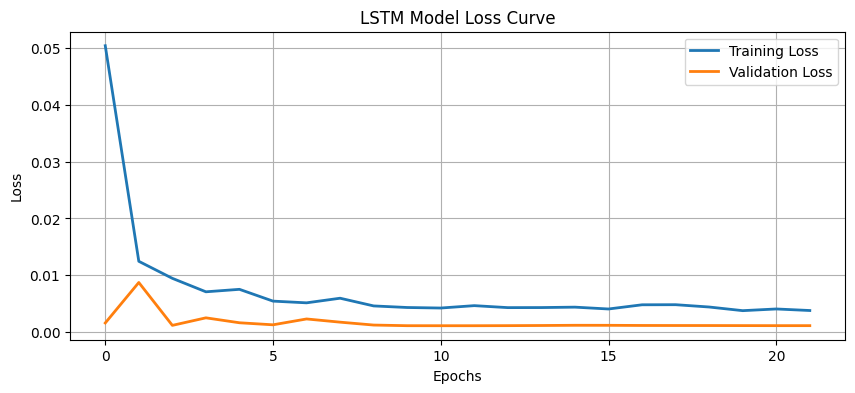

In [ ]:
#code cell 17
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title("LSTM Model Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()



XG Boost model training

In [ ]:
#code cell 18
# === Build the XGBoost Regressor ===
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42
)

# === Train the model ===
xgb_model.fit(X_xgb_train, y_xgb_train)

# === Predict on test set ===
xgb_predictions = xgb_model.predict(X_xgb_test)

# === Print shapes and sample predictions ===
print(f"\nPredictions shape: {xgb_predictions.shape}")
print(f"First 5 predictions: {xgb_predictions[:5]}")
print(f"First 5 actuals: {y_xgb_test.values[:5]}")



Predictions shape: (43,)
First 5 predictions: [647.5198 670.3673 681.4577 694.7484 701.9221]
First 5 actuals: [680.3  682.85 708.5  720.8  707.7 ]


Weighted Hybrid Prediction

In [ ]:
#code cell 19
# === STEP 1: LSTM Predictions (scaled)
lstm_pred_scaled = lstm_model.predict(X_lstm_test)

# === STEP 2: Inverse Transform LSTM predictions to original scale
dummy = np.zeros((lstm_pred_scaled.shape[0], len(lstm_features)))
dummy[:, lstm_features.index('close')] = lstm_pred_scaled.reshape(-1)
# Inverse transform
lstm_pred_rescaled = scaler.inverse_transform(dummy)[:, lstm_features.index('close')]
# === STEP 3: XGBoost Predictions
xgb_pred = xgb_model.predict(X_xgb_test)
# === STEP 4: Align Lengths
min_len = min(len(lstm_pred_rescaled), len(xgb_pred))
lstm_pred_final = lstm_pred_rescaled[-min_len:]
xgb_pred_final = xgb_pred[-min_len:]
y_true_final = y_xgb_test.values[-min_len:]
# === STEP 5: Weighted Average (Hybrid Prediction)
w_lstm = 0.4
w_xgb = 0.6
hybrid_pred = (w_lstm * lstm_pred_final) + (w_xgb * xgb_pred_final)
# === STEP 6: Evaluation
rmse = np.sqrt(mean_squared_error(y_true_final, hybrid_pred))
mae = mean_absolute_error(y_true_final, hybrid_pred)
print("\n✅ Hybrid Model Evaluation (Weighted Average):")
print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step

✅ Hybrid Model Evaluation (Weighted Average):
RMSE: 14.04
MAE : 11.58


In [ ]:
#code cell 20
from sklearn.metrics import mean_squared_error, mean_absolute_error

# === Utility: Mean Absolute Percentage Error
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# === Evaluate LSTM
rmse_lstm = np.sqrt(mean_squared_error(y_true_final, lstm_pred_final))
mae_lstm = mean_absolute_error(y_true_final, lstm_pred_final)
mape_lstm = mean_absolute_percentage_error(y_true_final, lstm_pred_final)

# === Evaluate XGBoost
rmse_xgb = np.sqrt(mean_squared_error(y_true_final, xgb_pred_final))
mae_xgb = mean_absolute_error(y_true_final, xgb_pred_final)
mape_xgb = mean_absolute_percentage_error(y_true_final, xgb_pred_final)

# === Evaluate Hybrid
rmse_hybrid = np.sqrt(mean_squared_error(y_true_final, hybrid_pred))
mae_hybrid = mean_absolute_error(y_true_final, hybrid_pred)
mape_hybrid = mean_absolute_percentage_error(y_true_final, hybrid_pred)

# === Print Evaluation Table
print("\n📈 Model Evaluation (Lower is Better):")
print("{:<10} {:>10} {:>10} {:>10}".format("Model", "RMSE", "MAE", "MAPE"))
print("-" * 42)
print("{:<10} {:>10.2f} {:>10.2f} {:>10.2f}".format("LSTM", rmse_lstm, mae_lstm, mape_lstm))
print("{:<10} {:>10.2f} {:>10.2f} {:>10.2f}".format("XGBoost", rmse_xgb, mae_xgb, mape_xgb))
print("{:<10} {:>10.2f} {:>10.2f} {:>10.2f}".format("Hybrid", rmse_hybrid, mae_hybrid, mape_hybrid))




📈 Model Evaluation (Lower is Better):
Model            RMSE        MAE       MAPE
------------------------------------------
LSTM            18.27      14.96       2.14
XGBoost         15.71      12.83       1.82
Hybrid          14.04      11.58       1.64


/tmp/ipython-input-21-2827330027.py:15: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


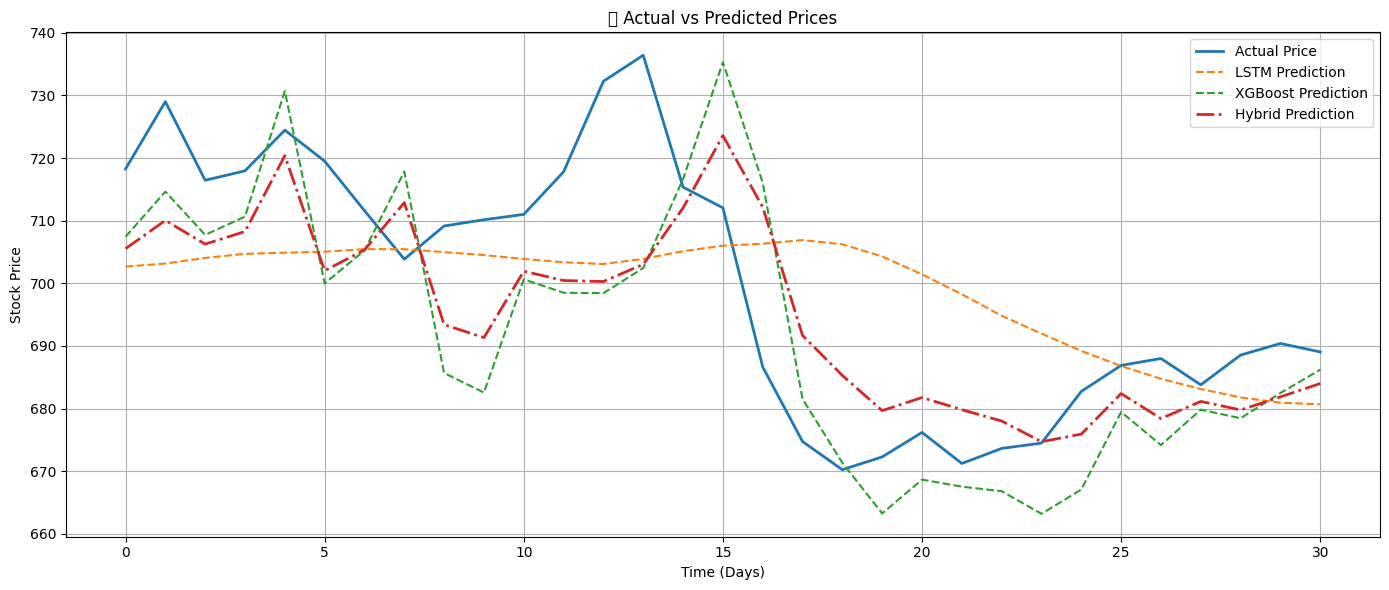

/tmp/ipython-input-21-2827330027.py:28: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


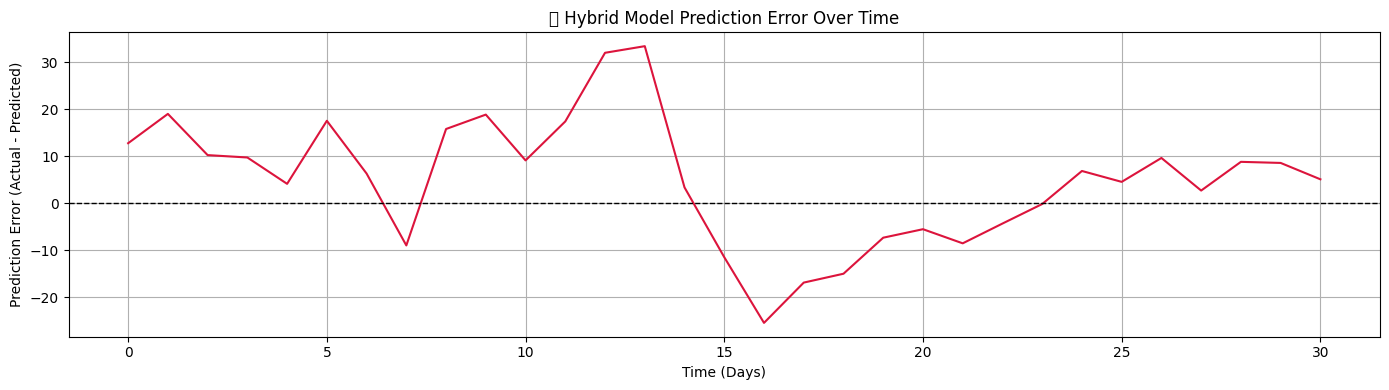

In [ ]:
#code cell 21
import matplotlib.pyplot as plt

# === Plot 1: Actual vs Predicted Prices (Hybrid, LSTM, XGBoost) ===
plt.figure(figsize=(14, 6))
plt.plot(y_true_final, label='Actual Price', linewidth=2)
plt.plot(lstm_pred_final, label='LSTM Prediction', linestyle='--')
plt.plot(xgb_pred_final, label='XGBoost Prediction', linestyle='--')
plt.plot(hybrid_pred, label='Hybrid Prediction', linestyle='-.', linewidth=2)
plt.title("📈 Actual vs Predicted Prices")
plt.xlabel("Time (Days)")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot 2: Prediction Error over Time (Hybrid Model) ===
hybrid_error = y_true_final - hybrid_pred

plt.figure(figsize=(14, 4))
plt.plot(hybrid_error, color='crimson')
plt.title("📉 Hybrid Model Prediction Error Over Time")
plt.xlabel("Time (Days)")
plt.ylabel("Prediction Error (Actual - Predicted)")
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.grid(True)
plt.tight_layout()
plt.show()



/tmp/ipython-input-22-4092851034.py:28: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


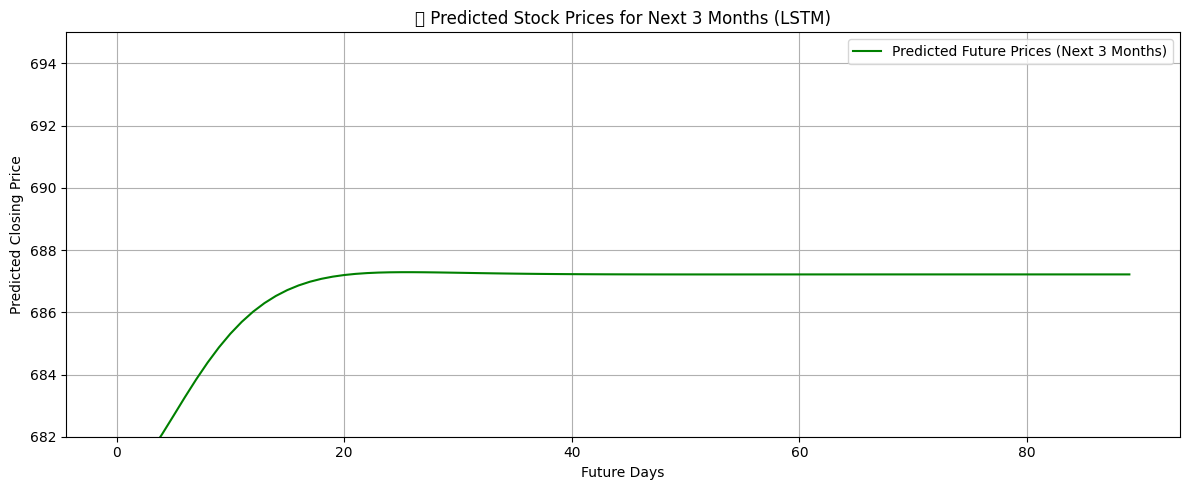

In [ ]:
#code cell 22
# === Predict Next 3 Months (90 trading days) ===
n_days = 90
last_input = X_lstm_test[-1]  # shape: (timesteps, features)
future_predictions = []
# Clone input to avoid modifying original
current_input = last_input.copy()
for _ in range(n_days):
    input_reshaped = current_input.reshape(1, current_input.shape[0], current_input.shape[1])
    next_scaled = lstm_model.predict(input_reshaped, verbose=0)[0][0]
    next_input = current_input[-1].copy()
    next_input[lstm_features.index('close')] = next_scaled
    future_predictions.append(next_input.copy())
    current_input = np.vstack([current_input[1:], next_input])
# === Inverse Transform Predictions to Original Scale ===
dummy_full = np.zeros((n_days, len(lstm_features)))
for i in range(n_days):
    dummy_full[i, lstm_features.index('close')] = future_predictions[i][lstm_features.index('close')]
future_rescaled = scaler.inverse_transform(dummy_full)[:, lstm_features.index('close')]
plt.figure(figsize=(12, 5))
plt.ylim(682, 695)
plt.plot(future_rescaled, label='Predicted Future Prices (Next 3 Months)', color='green')
plt.title("📈 Predicted Stock Prices for Next 3 Months (LSTM)")
plt.xlabel("Future Days")
plt.ylabel("Predicted Closing Price")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



In [1]:
!git clone https://github.com/sharman-404/Stock-price-prediction.git

Cloning into 'Stock-price-prediction'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), done.
